# search progress visualization used in movie

In [1]:
using Revise
import Random: seed!
import Printf: @sprintf, @printf
using MRMP
using MRMP.Solvers
import DataStructures: PriorityQueue, enqueue!, dequeue!
using Plots

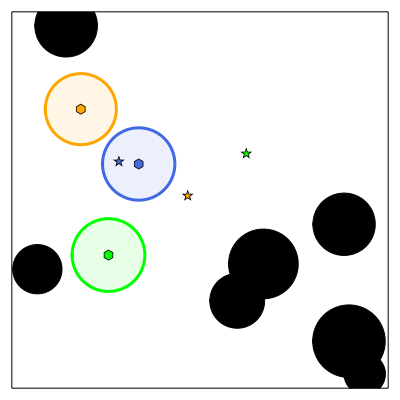

In [2]:
seed!(13)
ins = MRMP.gen_random_instance_StatePoint2D(;
    N = 3,
    rad_min = 0.05,
    rad_max = 0.1,
    num_obs = 8,
    rad_obs_min = 0.05,
    rad_obs_max = 0.10,
)
config_init, config_goal, obstacles, ins_params... = ins
connect = gen_connect(config_init[1], obstacles, ins_params...)
collide = gen_collide(config_init[1], ins_params...)
check_goal = gen_check_goal(config_goal)
planner_args = [config_init, config_goal, connect, collide, check_goal]
MRMP.plot_instance!(ins...)

In [6]:
epsilon = 0.2
init_min_dist_thread = 0.1
steering_depth = 2
num_vertex_expansion = 10

seed!(2)

# number of agents
N = length(config_init)

# define sampler
sampler = MRMP.gen_uniform_sampling(config_init[1])

# used in steering
conn(q_from, q_to, i) = begin
    (isnothing(epsilon) || MRMP.dist(q_from, q_to) <= epsilon) && connect(q_from, q_to, i)
end

roadmaps = MRMP.Solvers.LibSSSP.gen_RRT_connect_roadmaps(
    config_init,
    config_goal,
    connect;
    steering_depth = steering_depth,
    epsilon = epsilon,
)

# setup distance tables
distance_tables = MRMP.Solvers.get_distance_tables(roadmaps)

# setup heuristic function
h_func(Q) = sum(map(i -> distance_tables[i][Q[i].id], 1:N)) / N

# initial configuration
Q_init = [roadmaps[i][1] for i = 1:N]

# initial search node
S_init = MRMP.Solvers.LibSSSP.SuperNode(Q = Q_init, next = 1, id = MRMP.Solvers.LibSSSP.get_Q_id(Q_init, 0), h = h_func(Q_init))

# store best node
S_best = S_init
f_best = S_init.f

# open list
OPEN = PriorityQueue{MRMP.Solvers.LibSSSP.SuperNode{MRMP.StatePoint2D},Float64}()

# discovered list to avoid duplication
VISITED = Dict{String,MRMP.Solvers.LibSSSP.SuperNode{MRMP.StatePoint2D}}()

# threshold of space-filling metric
min_dist_thread = init_min_dist_thread

# setup initail node
enqueue!(OPEN, S_init, S_init.f)
VISITED[S_init.id] = S_init

arr_roadmaps = []
arr_config = []
push!(arr_roadmaps, deepcopy(roadmaps))
push!(arr_config, Q_init)

solution = nothing

while !isempty(OPEN)

    # pop
    S = dequeue!(OPEN)

    # check goal
    if check_goal(S.Q)
        push!(arr_roadmaps, deepcopy(roadmaps))
        push!(arr_config, S.Q)
        solution = MRMP.Solvers.LibSSSP.backtrack(S, VISITED)
        break
    end

    # initial search or update for refine agents
    i = S.next
    j = mod1(S.next + 1, N)

    v = S.Q[i]

    # explore new states
    MRMP.Solvers.LibSSSP.expand!(
        (q_from, q_to) -> conn(q_from, q_to, i),
        sampler,
        v,
        roadmaps[i],
        min_dist_thread,
        num_vertex_expansion,
        steering_depth,
    ) && (distance_tables[i] = MRMP.Solvers.get_distance_table(roadmaps[i]))

    push!(arr_roadmaps, deepcopy(roadmaps))
    push!(arr_config, S.Q)

    # expand search node
    for p_id in vcat(v.neighbors, [v.id])

        # create new configuration
        p = roadmaps[i][p_id]
        Q = copy(S.Q)
        Q[i] = p

        # check duplication and collision
        Q_id = MRMP.Solvers.LibSSSP.get_Q_id(Q, j)
        haskey(VISITED, Q_id) && continue
        collide(S.Q, p.q, i) && continue

        # create new search node
        S_new = MRMP.Solvers.LibSSSP.SuperNode(
            Q = Q,
            next = j,
            id = Q_id,
            parent_id = S.id,
            h = h_func(Q),
            depth = S.depth + 1,
        )

        # insert
        enqueue!(OPEN, S_new, S_new.f)
        VISITED[S_new.id] = S_new

        # update best one
        if S_new.f < f_best
            S_best = S_new
            f_best = S_new.f
        end
    end
end

plotting k=50/50

┌ Info: Saved animation to 
│   fn = /Users/Kei18/Dropbox/work/project/massive-control/simulator/notebooks/fig/search-progress.gif
└ @ Plots /Users/Kei18/.julia/packages/Plots/iT5yO/src/animation.jl:114


Plots.AnimatedGif("/Users/Kei18/Dropbox/work/project/massive-control/simulator/notebooks/fig/search-progress.gif")
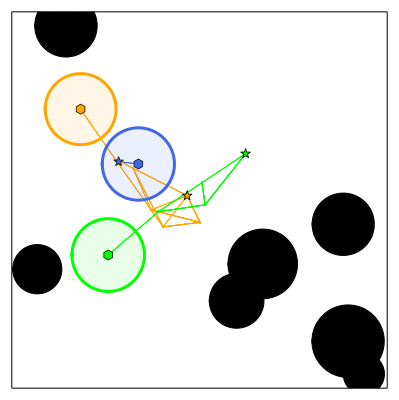

In [7]:
anim = @animate for k in 1:length(arr_roadmaps)
    roadmaps = arr_roadmaps[k]
    Q = arr_config[k]
    @printf("\rplotting k=%d/%d", k, length(arr_roadmaps))
    MRMP.plot_init!(MRMP.StatePoint2D)
    MRMP.plot_obs!(obstacles)
    MRMP.plot_roadmap!(roadmaps, ins_params...; lw=1.0)
    MRMP.plot_start_goal!(config_init, config_goal, ins_params...)
    for (i, v) in enumerate(Q)
        MRMP.plot_agent!(v.q, map(arr -> arr[i], ins_params)..., MRMP.get_color(i))
    end
end
gif(anim, "./fig/search-progress.gif", fps = 10)

plotting t = 29 / 28


┌ Info: Saved animation to 
│   fn = /Users/Kei18/Dropbox/work/project/massive-control/simulator/notebooks/fig/search-result.gif
└ @ Plots /Users/Kei18/.julia/packages/Plots/iT5yO/src/animation.jl:114


Plots.AnimatedGif("/Users/Kei18/Dropbox/work/project/massive-control/simulator/notebooks/fig/search-result.gif")
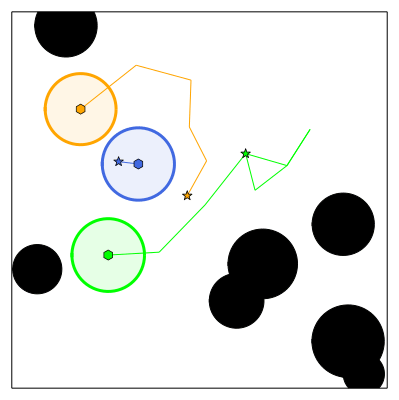

In [8]:
plot_anim!(config_init, config_goal, obstacles, ins_params...; solution=solution, interpolate_depth=2,　VERBOSE=1, filename = "./fig/search-result.gif")